In [21]:
# common packages 
import numpy as np 
import os
import copy
from math import *
import matplotlib.pyplot as plt
from functools import reduce
# reading in dicom files
import pydicom
# skimage image processing packages
from skimage import measure, morphology
from skimage.morphology import ball, binary_closing
from skimage.measure import label, regionprops
# scipy linear algebra functions 
from scipy.linalg import norm
import scipy.ndimage
# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets
# plotly 3D interactive graphs 
import plotly
from plotly.graph_objs import *
import chart_studio.plotly as py
# set plotly credentials here 
# this allows you to send results to your account plotly.tools.set_credentials_file(username=your_username, api_key=your_key)

In [22]:
def load_scan(path):
    slices = [pydicom.dcmread(path + "/" + s) for s in               
              os.listdir(path)]
    slices = [s for s in slices if "SliceLocation" in s]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    for s in slices:
        s.SliceThickness = slice_thickness
    return slices
    
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)
    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    # intercept = scans[0].RescaleIntercept
    # slope = scans[0].RescaleSlope
    
    # if slope != 1:
    #     image = slope * image.astype(np.float64)
    #     image = image.astype(np.int16)
        
    # image += np.int16(intercept)

    for slice_number in range(len(scans)):
        
        intercept = scans[slice_number].RescaleIntercept
        slope = scans[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

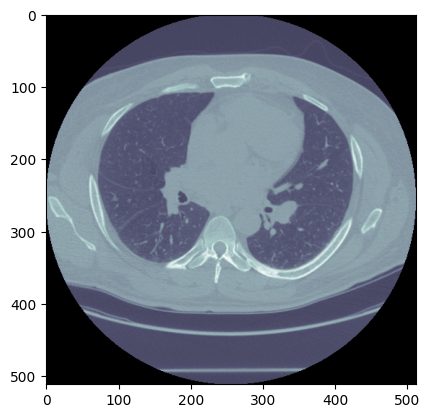

In [48]:
# set path and load files 

folder = "D:/FBK/Clinical Data/3-13-2023/"
patients = os.listdir(folder)
patients.sort()
patient_dicom = load_scan(folder + patients[0] + '/CT')
patient_pixels = get_pixels_hu(patient_dicom)
#sanity check
plt.imshow(patient_pixels[111], cmap=plt.cm.bone)

In [28]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)
    counts = counts[vals != bg]
    vals = vals[vals != bg]
    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None
def segment_lung_mask(image, fill_lung_structures=True):
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image >= -700, dtype=np.int8)+1
    labels = measure.label(binary_image)
 
    # Pick the pixel in the very corner to determine which label is air.
    # Improvement: Pick multiple background labels from around the  patient
    # More resistant to “trays” on which the patient lays cutting the air around the person in half
    background_label = labels[0,0,0]
 
    # Fill the air around the person
    binary_image[background_label == labels] = 2
 
    # Method of filling the lung structures (that is superior to 
    # something like morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
 
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
 
    # Remove other air pockets inside body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

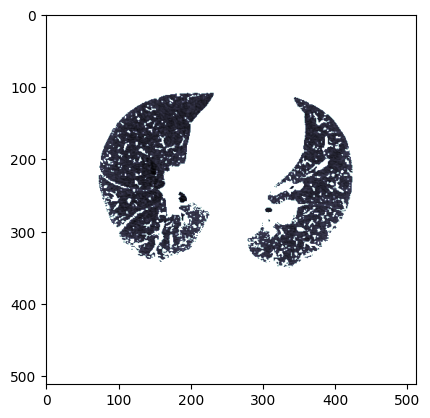

In [49]:
# get masks 
segmented_lungs = segment_lung_mask(patient_pixels,    
                  fill_lung_structures=True)
segmented_lungs_fill = segment_lung_mask(patient_pixels,     
                       fill_lung_structures=False)
internal_structures = segmented_lungs_fill - segmented_lungs
# isolate lung from chest
copied_pixels = copy.deepcopy(patient_pixels)
for i, mask in enumerate(segmented_lungs_fill): 
    get_high_vals = mask == 0
    copied_pixels[i][get_high_vals] = 0
seg_lung_pixels = copied_pixels
# sanity check
plt.imshow(seg_lung_pixels[111], cmap=plt.cm.bone)

In [43]:
class GK:
    def __init__(self, n_clusters=4, max_iter=100, m=2, error=1e-6):
        super().__init__()
        self.u, self.centers, self.f = None, None, None
        self.clusters_count = n_clusters
        self.max_iter = max_iter
        self.m = m
        self.error = error
    def fit(self, z):
                N = z.shape[0]
                C = self.clusters_count
                centers = []
                u = np.random.dirichlet(np.ones(N), size=C)
                iteration = 0
                while iteration < self.max_iter:
                    u2 = u.copy()
                    centers = self.next_centers(z, u)
                    f = self._covariance(z, centers, u)
                    dist = self._distance(z, centers, f)
                    u = self.next_u(dist)
                    iteration += 1
                    # Stopping rule
                    if norm(u - u2) < self.error:
                        break
                self.f = f
                self.u = u
                self.centers = centers
                return centers


In [44]:
def gk_segment(img, clusters=5, smooth=False):
        # expand dims of binary image (1 channel in z axis)
        new_img = np.expand_dims(img, axis=2)
        # reshape
        x, y, z = new_img.shape
        new_img = new_img.reshape(x * y, z)
        # segment using GK clustering
        algorithm = GK(n_clusters=clusters)
        cluster_centers = algorithm.fit(new_img)
        output = algorithm.predict(new_img)
        segments = cluster_centers[output].astype(np.int32).reshape(x,y)
        # get cluster that takes up least space (nodules / airway)
        min_label = min_label_volume(segments)
        segments[np.where(segments != min_label)] = 0
        segments[np.where(segments == min_label)] = 1
        return segments

Now, lets segment only a few slices (5 of them) using the GK Clustering class and display one of them!

In [45]:
# cluster slices (#324 - #328)
dist = 2
selected_slices = seg_lung_pixels[180-dist:180+(dist+1)]
gk_clustered_imgs = np.array([gk_segment(x) for x in    
                              selected_slices])
# display middle slice (slice #326)
plt.imshow(gk_clustered_imgs[2], cmap=plt.cm.bone)

AttributeError: 'GK' object has no attribute 'next_centers'